# 1. Import & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
import collections
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

In [2]:
Env = pd.read_csv("./environment_tocken.csv", encoding='utf-8-sig')

# 명사 수가 50개를 넘어가는 경우만 추출
Env = Env[Env['명사수'] >= 50]
Env = Env.reset_index(drop=True)

# ['토큰'] 칼럼 콤마 기준 스플릿
for i in range(len(Env)):

    env_tocken=[]

    Env['토큰'][i] = Env['토큰'][i][1:-1].split(', ')
    for j in Env['토큰'][i]:
        env_tocken.append(j[1:-1])

    Env['토큰'][i] = env_tocken

Env.head(1)

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Unnamed: 0,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,법률안,제안정당,법률공포여부,텍스트,토큰,명사수
0,0,2000042,처,해양환경관리법 일부개정법률안,의원,2016-05-30,2016-12-08 00:00:00,대안반영폐기,NaN,의안원문\r\n비용추계서 미첨부 사유서,제20대 (2016~2020) 제342회,최근 국제해사기구(IMO)의 온실가스 유해물질 평형수 등의 환경 관련 규제가 순차적...,농림축산식품해양수산위원회,"[""['김성찬(새누리당/金盛贊)'"", "" '경대수(새누리당/慶大秀)'"", "" '김재...",1.0,"['더불어민주당', '새누리당']",미공포,해양환경관리법 일부개정법률안 최근 국제해사기구의 온실가스 유해물질 평형수 등의 ...,"[해양, 환경, 관리, 일부, 개정, 법률, 최근, 국제, 기구, 온실가스, 유해,...",83


In [3]:
Env_cluster = pd.read_csv("./kmeans_3clusters.csv", encoding='utf-8-sig')
Env_cluster.columns = Env_cluster.columns.str.replace("BillNo","의안번호")
Env_cluster.drop('BillName', axis=1, inplace=True)
Env_cluster = Env_cluster.reset_index(drop=True)
Env_cluster.head(1)

,Unnamed: 0,x_coord,y_coord,의안번호,cluster_no,color
0,0,42.47668,31.542627,2000042,2,#fc8d59


### TopicModeling용 데이터셋 만들기
env('환경' 키워드를 포함하는 의안데이터)와 env_cluster(env 데이터를 3개의 군집으로 나눈 후 클러스터 번호를 저장한 데이터)를 '의안번호'를 기준으로 합친다. 

In [4]:
env = pd.merge(Env, Env_cluster, on = "의안번호", how="inner")
env.head(1)

,Unnamed: 0_x,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,...,제안정당,법률공포여부,텍스트,토큰,명사수,Unnamed: 0_y,x_coord,y_coord,cluster_no,color
0,0,2000042,처,해양환경관리법 일부개정법률안,의원,2016-05-30,2016-12-08 00:00:00,대안반영폐기,NaN,의안원문\r\n비용추계서 미첨부 사유서,...,"['더불어민주당', '새누리당']",미공포,해양환경관리법 일부개정법률안 최근 국제해사기구의 온실가스 유해물질 평형수 등의 ...,"[해양, 환경, 관리, 일부, 개정, 법률, 최근, 국제, 기구, 온실가스, 유해,...",83,0,42.47668,31.542627,2,#fc8d59


### 클러스터 별로 나누어 데이터셋 만들기

In [5]:
# cluster_no == 0
env_0 = env[env['cluster_no']==0]
env_0 = env_0.reset_index(drop=True)
env_0['cluster_no'].describe()

count    942.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: cluster_no, dtype: float64

In [6]:
# cluster_no == 1
env_1 = env[env['cluster_no']==1]
env_1 = env_1.reset_index(drop=True)
env_1['cluster_no'].describe()

count    900.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: cluster_no, dtype: float64

In [7]:
# cluster_no == 2
env_2 = env[env['cluster_no']==2]
env_2 = env_2.reset_index(drop=True)
env_2['cluster_no'].describe()

count    1253.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
Name: cluster_no, dtype: float64

# 2. TopicMdeling을 위한 함수 생성

In [8]:
# 의미 없는 단어 삭제

def remove_stopword(text): 
    stopwords = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근'
    ,'집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', '명시', '촉진', 
                 '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해']
    text = [word for word in text if word not in stopwords]
    return text


# 말뭉치

def make_corpus(cleanlist):

    dictionary = corpora.Dictionary(cleanlist) # cleanlist = 토큰화 한 리스트
    corpus = [dictionary.doc2bow(text) for text in cleanlist] # 벡터화 한 리스트 or 그냥 ㄱ
    
    return corpus, dictionary, cleanlist




# 많이 나오는 단어 확인

def check_common(cleanlist):
    

    collections.Counter()

    flat=[]
    for i in cleanlist:
        for j in i:
            flat.append(j)
                    
                    
    commoncount = collections.Counter(flat)
    commoncount = commoncount.most_common(20) # 상위 20개 단어 + 빈도수가 들어있음

    commondict = [] # 제거할 수 있으므로 상위 20개 단어만 리스트에 넣어놓기

    for i in range(len(commoncount)): #50
        commondict.append(commoncount[i][0])

    commoncount

    return commoncount, commondict




# 토픽 수 최적화

def coh_visual(corpus, dictionary, cleanlist):
    
    coherence_values = []
    
    for i in tqdm(range(2,20), desc = 'coh'):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
    
    x = range(2,20)
    plt.plot(x, coherence_values)
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.show()
    



# 언어모델 평가

def perp_visual(corpus, dictionary):
    
    perplexity_values = []
    
    for i in tqdm(range(2,20),desc = 'perp'):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
    
    x = range(2,20)
    plt.plot(x, perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()


# 사이킷런 - LDA
def display_topics(model, feature_names, no_top_words):
    
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)
        
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes = topic_word_indexes[:no_top_words]
        
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        

# 3. 토픽모델링 with Gensim

## 0번 클러스터

### 무의미한 단어삭제 및 빈도수 높은  단어 확인

In [14]:
# 무의미한 단어 삭제
for i in range(len(env_0)):
    env_0['토큰'][i] = remove_stopword(env_0['토큰'][i])

env_0_clean = env_0['토큰']

# 빈도 수 높은 단어 출력
env_0_commoncount, env_0_commondict = check_common(env_0_clean)
env_0_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('제조', 2071),
 ('시설', 1581),
 ('환경', 1519),
 ('안전', 1320),
 ('자동차', 790),
 ('기준', 789),
 ('배출', 708),
 ('설치', 687),
 ('지역', 608),
 ('물질', 605),
 ('폐기물', 574),
 ('환경부', 525),
 ('사용', 513),
 ('처리', 488),
 ('국민', 458),
 ('개선', 425),
 ('교육', 411),
 ('이용', 402),
 ('인증', 401),
 ('제도', 398)]

### 말뭉치 만들기

In [10]:
env_0_corpus, env_0_dictionary, env_0_cleanlist = make_corpus(env_0_clean)

### Topic 수 결정

coh: 100%|██████████| 18/18 [00:28<00:00,  1.57s/it]


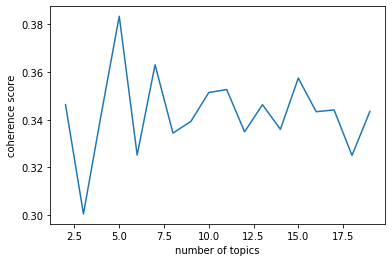

In [11]:
coh_visual(env_0_corpus, env_0_dictionary, env_0_cleanlist)

perp: 100%|██████████| 18/18 [00:33<00:00,  1.88s/it]


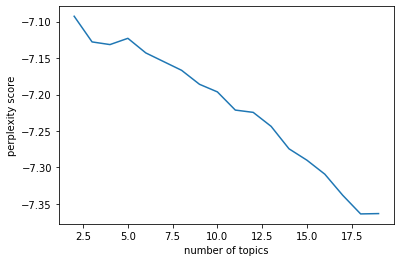

In [12]:
perp_visual(env_0_corpus, env_0_dictionary)

=> number of topics = 4로 결정

### 토픽모델링 시각화 - Gensim

In [19]:
ldamodel = gensim.models.ldamodel.LdaModel(env_0_corpus, num_topics=4, alpha=0.1, id2word = env_0_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, env_0_corpus, env_0_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.030596  0.010566       1        1  29.033220
1      0.009330 -0.041264       2        1  26.035843
3      0.043239  0.021205       3        1  25.592569
0     -0.021972  0.009493       4        1  19.338377, topic_info=     Term         Freq        Total Category  logprob  loglift
3282   급식   188.000000   188.000000  Default  30.0000  30.0000
34     배출   698.000000   698.000000  Default  29.0000  29.0000
434    측정   378.000000   378.000000  Default  28.0000  28.0000
72    자동차   773.000000   773.000000  Default  27.0000  27.0000
319    안전  1236.000000  1236.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
13     국민    76.192146   436.620483   Topic4  -5.4945  -0.1027
34     배출    83.508720   698.037659   Topic4  -5.4028  -0.4802
30     물질    76.259361   587.057739   Topic4  -5.4936  -0.3979
247    피해    65.366348   374.005798   Topic4  -5.6477  -0.1012
274   환경부    63.077866   501.884216   Topic4  -5.6834  -0.4309

[341 rows x 6 columns], token_table=      Topic      Freq Term
term                      
604       4  0.709073   가상
0         1  0.259652   가스
0         2  0.135470   가스
0         3  0.491080   가스
0         4  0.118537   가스
...     ...       ...  ...
274       1  0.268986  환경부
274       2  0.294889  환경부
274       3  0.308836  환경부
274       4  0.125527  환경부
4909      1  0.846747   흥미

[750 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

### 토픽모델링 - 사이킷런 LDA

In [16]:
env_0_clean_flat=[]

for i in env_0_clean:
    for j in i:
        env_0_clean_flat.append(j)

env_0_count_vect = CountVectorizer(max_df = 1.0, max_features = 1000, min_df = 10, ngram_range = (1,2))
env_0_fit_vect = env_0_count_vect.fit_transform(env_0_clean_flat)

env_0_lda = LatentDirichletAllocation(n_components = 4, random_state = 0)
env_0_lda.fit(env_0_fit_vect)
        
env_0_feature_names = env_0_count_vect.get_feature_names()

display_topics(env_0_lda, env_0_feature_names, 15)

Topic # 0
시설 환경 폐기물 국민 개선 건강 보호 유해 사고 검사 구역 수입 위반 상황 허용
Topic # 1
배출 지역 화학물질 재활용 대하 정보 대기오염 차량 기간 금지 기술 교통 예방 이행 대기
Topic # 2
제조 안전 자동차 기준 설치 환경부 사용 처리 교육 이용 인증 제도 영향 피해 제품
Topic # 3
물질 측정 부과 미세먼지 계획 평가 대상 신고 허가 등록 업자 주민 산업 우려 이상


**=> '폐기물', '유해', '화학물질', '재활용', '대기오염', '차량', '배출', '자동차', '미세먼지'**

**: '자연환경'의 오염을 방지하기 위한 의안일 가능성이 높다!**

## 1번 클러스터

### 무의미한 단어 삭제 및 빈도수 높은 단어 확인

In [9]:
# 무의미한 단어 삭제
for i in range(len(env_1)):
    env_1['토큰'][i] = remove_stopword(env_1['토큰'][i])

env_1_clean = env_1['토큰']

# 빈도 수 높은 단어 출력
env_1_commoncount, env_1_commondict = check_common(env_1_clean)
env_1_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('제조', 2234),
 ('환경', 1276),
 ('근로자', 697),
 ('보호', 672),
 ('사회', 663),
 ('행위', 650),
 ('교육', 494),
 ('피해', 472),
 ('제도', 461),
 ('정보', 460),
 ('개선', 423),
 ('서비스', 421),
 ('제공', 412),
 ('기업', 409),
 ('의료', 400),
 ('활동', 400),
 ('장애인', 396),
 ('근로', 374),
 ('시설', 374),
 ('국민', 354)]

### 말뭉치 만들기

In [10]:
env_1_corpus, env_1_dictionary, env_1_cleanlist = make_corpus(env_1_clean)

### Topic 수 결정

coh: 100%|██████████| 18/18 [00:29<00:00,  1.62s/it]


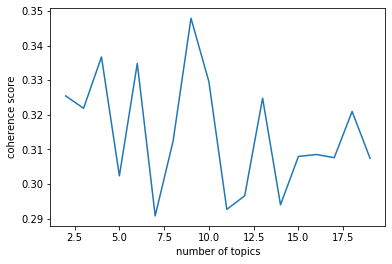

In [11]:
coh_visual(env_1_corpus, env_1_dictionary, env_1_cleanlist)

perp: 100%|██████████| 18/18 [00:34<00:00,  1.90s/it]


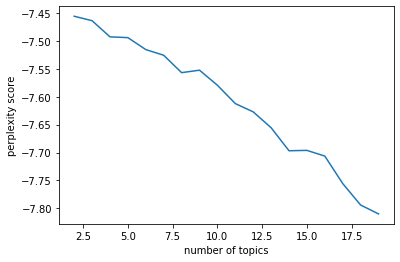

In [12]:
perp_visual(env_1_corpus, env_1_dictionary)

=> number of topics = 6으로 결정

### 토픽모델링 시각화 - Gensim

In [11]:
ldamodel = gensim.models.ldamodel.LdaModel(env_1_corpus, num_topics=6, alpha=0.1, id2word = env_1_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, env_1_corpus, env_1_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.024102  0.000102       1        1  22.046364
4      0.016421 -0.010874       2        1  20.710863
0      0.052988  0.001913       3        1  16.252792
1     -0.007262 -0.046931       4        1  14.999326
2      0.004776  0.044705       5        1  13.324009
5     -0.042820  0.011085       6        1  12.666647, topic_info=     Term        Freq       Total Category  logprob  loglift
775    가맹  207.000000  207.000000  Default  30.0000  30.0000
187    아동  333.000000  333.000000  Default  29.0000  29.0000
1136  벌금형  172.000000  172.000000  Default  28.0000  28.0000
3324  양육비   87.000000   87.000000  Default  27.0000  27.0000
4      교육  472.000000  472.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
802    예방   38.586861  260.634338   Topic6  -5.8654   0.1560
262    범위   37.677059  225.544907   Topic6  -5.8892   0.2767
537   근로자   42.613155  648.606750   Topic6  -5.7661  -0.6565
130    제공   39.207878  389.534271   Topic6  -5.8494  -0.2299
124    안전   38.593632  312.420258   Topic6  -5.8652  -0.0251

[497 rows x 6 columns], token_table=      Topic      Freq Term
term                      
775       1  0.014475   가맹
775       2  0.091672   가맹
775       3  0.781628   가맹
775       4  0.004825   가맹
775       5  0.101322   가맹
...     ...       ...  ...
1632      3  0.056178   휴가
1632      4  0.037452   휴가
1632      5  0.112357   휴가
1632      6  0.018726   휴가
4545      5  0.763136   희소

[1487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3, 6])

### 토픽모델링 - 사이킷런 LDA

In [19]:
env_1_clean_flat=[]

for i in env_1_clean:
    for j in i:
        env_1_clean_flat.append(j)

env_1_count_vect = CountVectorizer(max_df = 1.0, max_features = 1000, min_df = 10, ngram_range = (1,2))
env_1_fit_vect = env_1_count_vect.fit_transform(env_1_clean_flat)

env_1_lda = LatentDirichletAllocation(n_components = 6, random_state = 0)
env_1_lda.fit(env_1_fit_vect)
        
env_1_feature_names = env_1_count_vect.get_feature_names()

display_topics(env_1_lda, env_1_feature_names, 15)

Topic # 0
환경 서비스 제공 시설 산업 예방 위반 방송 기금 신고 침해 계약 거래 회사 재해
Topic # 1
행위 제도 장애인 안전 문제 복지 이용 설치 금지 조성 권리 가정 가습기 실정 피해자
Topic # 2
보호 사회 개선 의료 국민 범죄 적용 사용 보험 직장 체계 필요 사유 결과 요구
Topic # 3
아동 기준 수행 청소년 평가 가맹 목적 인정 살균제 여성 벌금형 의결 문화 조정 근무
Topic # 4
제조 활동 건강 대하 대상 조치 공무원 이상 상황 고용 정책 지방자치단체 급여 범위 개인
Topic # 5
근로자 교육 피해 정보 기업 근로 사업자 보장 기간 책임 처벌 확대 지급 확보 추가


**=> '서비스', '침해', '계약', '근로자', '장애인', '복지', '피해자', '의료', '범죄', '보험', '공무원', '보장', '고용'**

**: 인권을 보호받는 안전한 '사회환경'(근로, 의료 분야 등)을 만들기 위한 의안일 가능성이 높다!**

## 2번 클러스터

### 무의미한 단어 삭제 및 빈도수 높은 단어 확인

In [12]:
# 무의미한 단어 삭제
for i in range(len(env_2)):
    env_2['토큰'][i] = remove_stopword(env_2['토큰'][i])

env_2_clean = env_2['토큰']

# 빈도 수 높은 단어 출력
env_2_commoncount, env_2_commondict = check_common(env_2_clean)
env_2_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('제조', 3499),
 ('지역', 2230),
 ('환경', 1923),
 ('계획', 1505),
 ('시설', 1237),
 ('개발', 1114),
 ('발전', 1081),
 ('산업', 1029),
 ('수립', 869),
 ('지방자치단체', 862),
 ('기업', 801),
 ('교육', 785),
 ('정책', 751),
 ('추진', 734),
 ('학교', 668),
 ('설치', 657),
 ('사회', 655),
 ('개선', 634),
 ('구역', 622),
 ('기술', 593)]

### 말뭉치 만들기

In [13]:
env_2_corpus, env_2_dictionary, env_2_cleanlist = make_corpus(env_2_clean)

### Topic 수 결정

coh: 100%|██████████| 18/18 [00:39<00:00,  2.21s/it]


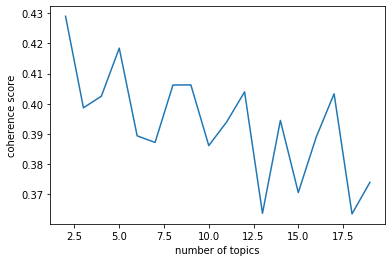

In [14]:
coh_visual(env_2_corpus, env_2_dictionary, env_2_cleanlist)

perp: 100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


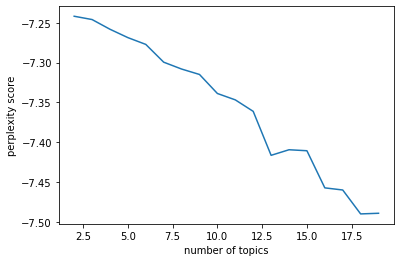

In [15]:
perp_visual(env_2_corpus, env_2_dictionary)

=> number of topics = 5로 결정

### 토픽 모델링 시각화 - Gensim

In [24]:
ldamodel = gensim.models.ldamodel.LdaModel(env_2_corpus, num_topics=5, alpha=0.1, id2word = env_2_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, env_2_corpus, env_2_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.025329  0.033790       1        1  23.267151
4      0.021809 -0.040819       2        1  21.491980
1     -0.006715  0.005919       3        1  21.376932
3      0.001771  0.002751       4        1  17.920151
0     -0.042194 -0.001641       5        1  15.943785, topic_info=     Term         Freq        Total Category  logprob  loglift
214    시설  1189.000000  1189.000000  Default  30.0000  30.0000
2403   복원   222.000000   222.000000  Default  29.0000  29.0000
264    학교   631.000000   631.000000  Default  28.0000  28.0000
50     환경  1827.000000  1827.000000  Default  27.0000  27.0000
48     해양   347.000000   347.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
956   에너지    92.216194   497.280945   Topic5  -5.5669   0.1511
34     이용    86.861122   464.487335   Topic5  -5.6267   0.1595
613    수립    95.717049   842.129761   Topic5  -5.5296  -0.3384
123    대상    83.830818   443.986603   Topic5  -5.6622   0.1691
73     설치    85.816154   635.588684   Topic5  -5.6388  -0.1662

[431 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1292      1  0.060341    가능
1292      2  0.087159    가능
1292      3  0.080454    가능
1292      4  0.616816    가능
1292      5  0.154204    가능
...     ...       ...   ...
5489      2  0.108368  회계감사
5489      4  0.650210  회계감사
5405      2  0.695865    후보
5405      3  0.139173    후보
5405      5  0.139173    후보

[1100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

### 토픽모델링 - 사이킷런 LDA

In [18]:
env_2_clean_flat=[]

for i in env_2_clean:
    for j in i:
        env_2_clean_flat.append(j)

env_2_count_vect = CountVectorizer(max_df = 1.0, max_features = 1000, min_df = 10, ngram_range = (1,2))
env_2_fit_vect = env_2_count_vect.fit_transform(env_2_clean_flat)

env_2_lda = LatentDirichletAllocation(n_components = 5, random_state = 0)
env_2_lda.fit(env_2_fit_vect)
        
env_2_feature_names = env_2_count_vect.get_feature_names()

display_topics(env_2_lda, env_2_feature_names, 15)

Topic # 0
개발 기업 추진 적용 국민 에너지 규제 종합 진흥 지방 주변 세액 토지 자원 보급
Topic # 1
산업 수립 교육 설치 사회 투자 활성화 도시 정부 의결 평가 조성 부담 해양 대하
Topic # 2
지역 환경 발전 지방자치단체 개선 기술 체계 이용 대상 확보 경제 주거 공급 한국 사업자
Topic # 3
계획 시설 정책 학교 정비 주택 안전 사용 조정 설립 목적 상황 영향 노인 수행
Topic # 4
제조 구역 제도 주민 특례 확대 기준 지속 소음 활용 필요 효율 이상 변경 문화


**=> '개발', '토지', '도시', '에너지', '발전', '주거', '학교', '주택', '주민', '소음'**

**: 도시 계획을 수립하거나 발전소를 설치하는 등 '거주환경'과 관련된 문제를 해결하기 위한 의안일 가능성이 높다!**